# Predicting the final grade of a student

The data used is from a Portuguese secondary school. The data includes academic and personal characteristics of the students as well as final grades.

I will try to predict if a student will fail the course or not. 

### [Link to dataset](https://archive.ics.uci.edu/ml/datasets/student+performance)

### Citation:

P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7.
[Web Link](http://www3.dsi.uminho.pt/pcortez/student.pdf)

### Reference [article](/home/dipamvasani7/Desktop/Ubuntu/jupyter_notebooks/data)

### Import the relevant modules

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Distributions
import scipy

In [3]:
df = pd.read_csv('../input/student-mat.csv')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


# EDA

## Basic analysis

In [4]:
print('Number of students:',df.shape[0])

Number of students: 395


In [5]:
print('Number of features:',df.shape[1])

Number of features: 33


## Grade 

**Final Grade**

The scale is from 0 to 20, with 20 being the best.

In [6]:
df['G3'].describe()

count    395.000000
mean      10.415190
std        4.581443
min        0.000000
25%        8.000000
50%       11.000000
75%       14.000000
max       20.000000
Name: G3, dtype: float64

**Correlation between the results of the exam**

In [7]:
df[['G3','G2','G1']].corr()

,G3,G2,G1
G3,1.000000,0.904868,0.801468
G2,0.904868,1.000000,0.852118
G1,0.801468,0.852118,1.000000


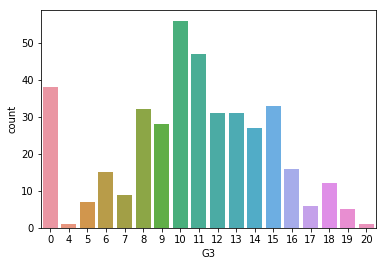

In [8]:
sns.countplot(x = 'G3', data = df)

We would expect the distribution to  be somewhat normal distributed, which it is in this case except for the grade being 0. 

Lets analyze this further by analzing if this pattern occurs for the other exams aswell.

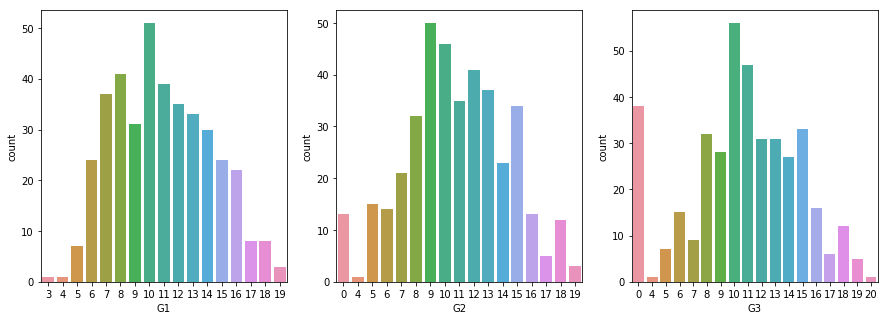

In [9]:
fig, axes = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.countplot(x = 'G1', data = df,ax=axes[0])
sns.countplot(x = 'G2', data = df,ax=axes[1])
sns.countplot(x = 'G3', data = df,ax=axes[2])

Here we clearly see that the exams have a similar pattern except for the grade of 0, which increases for each exam. 

According to [0], "During the school year, students are evaluated in three periods and the last evaluation (G3 of Table 1) corresponds to the final grade". This could that the large number of people getting a 0 in G3 means that there is large amount of people whom have failed the course and not a single exam. So if you failed either of G1 or G2 this could mean that G3 would be zero. However, this does not explain why there is a larger amount ofz zeros in G3 than for G2 and G1 combined. 

[0]: http://www3.dsi.uminho.pt/pcortez/student.pdf



**Perhaps, it could be a results of null values?**

In [10]:
print('Are there null values in the dataframe?:',df.isnull().any().any())

Are there null values in the dataframe?: False


Hmm, so no null values that explain the phenomenon of the zeros for G3. 

Lets see if there is any correlation between the final grade and any other feature. 

In [11]:
df.corr()['G3'].sort_values()


failures     -0.360415
age          -0.161579
goout        -0.132791
traveltime   -0.117142
health       -0.061335
Dalc         -0.054660
Walc         -0.051939
freetime      0.011307
absences      0.034247
famrel        0.051363
studytime     0.097820
Fedu          0.152457
Medu          0.217147
G1            0.801468
G2            0.904868
G3            1.000000
Name: G3, dtype: float64

# Failures

Is the number of classes failed. If the value is equal to 4, the person has failed 4 or more classes. For 0-3 the number is equals the number of classes failed.

In [12]:
df['failures'].describe()

count    395.000000
mean       0.334177
std        0.743651
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

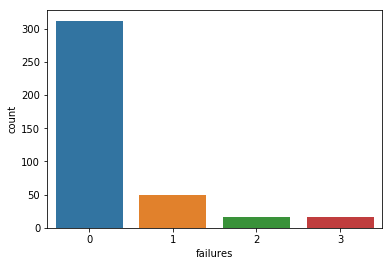

In [13]:
sns.countplot(x = 'failures', data = df)

Has the expected distribution, alltough I suspected it would be atleast one person with a 'failure' value of 4. 

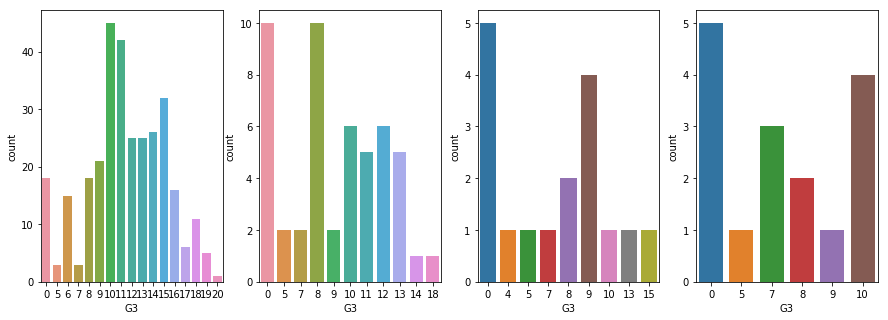

In [14]:
fig, axes = plt.subplots(1, 4)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.countplot(x = 'G3', data = df[df['failures']==0],ax=axes[0])
sns.countplot(x = 'G3', data = df[df['failures']==1],ax=axes[1])
sns.countplot(x = 'G3', data = df[df['failures']==2],ax=axes[2])
sns.countplot(x = 'G3', data = df[df['failures']==3],ax=axes[3])


Those whom have failed previously tend to have a worse final grade on average which is not unexpected. 

# Medu / Fedu 

The education level of the mother and father respectivly. 

In [15]:
df['Medu'].describe()

count    395.000000
mean       2.749367
std        1.094735
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

In [16]:
df['Fedu'].describe()

count    395.000000
mean       2.521519
std        1.088201
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: Fedu, dtype: float64

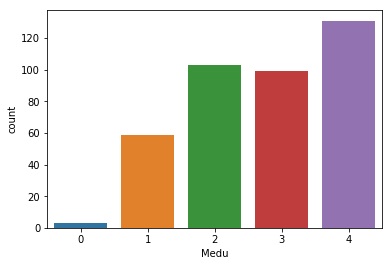

In [17]:
sns.countplot(x = 'Medu', data = df)

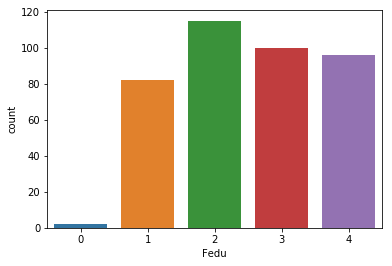

In [18]:
sns.countplot(x = 'Fedu', data = df)

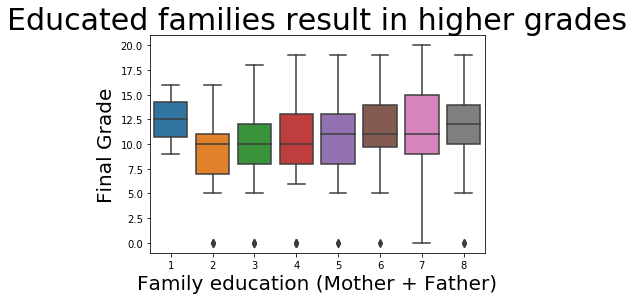

In [19]:
total_ed = df['Fedu'] + df['Medu'] 
b = sns.boxplot(x=total_ed,y=df['G3'])
b.axes.set_title('Educated families result in higher grades', fontsize = 30)
b.set_xlabel('Family education (Mother + Father)', fontsize = 20)
b.set_ylabel('Final Grade', fontsize = 20)
plt.show()


People with parents with longer eduaction history tend to perform better. Alltough the effect is not extreme. 


Lets see how this looks for people that got a final grade of 0. As the education level might not explain the average final grade, but could explain the number of persons that get a final grade = 0.

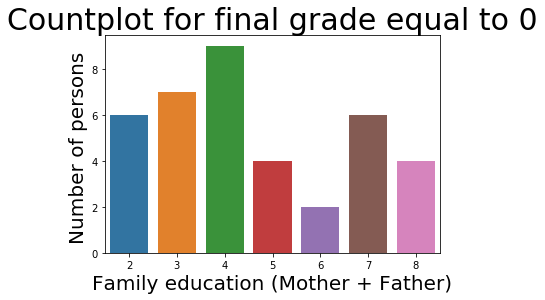

In [20]:
df_G3_0 = df.loc[df['G3'] == 0]
total_ed = df_G3_0['Fedu'] + df_G3_0['Medu'] 

b = sns.countplot(x=total_ed, data = df_G3_0)
b.axes.set_title('Countplot for final grade equal to 0', fontsize = 30)
b.set_xlabel('Family education (Mother + Father)', fontsize = 20)
b.set_ylabel('Number of persons ', fontsize = 20)
plt.show()


## Sex

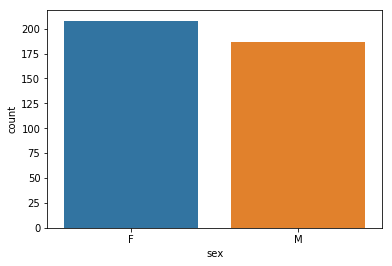

In [21]:
sns.countplot(x = 'sex', data = df)


The split is almost perfectly even, which is to be expected. 

**Sex and Grade**

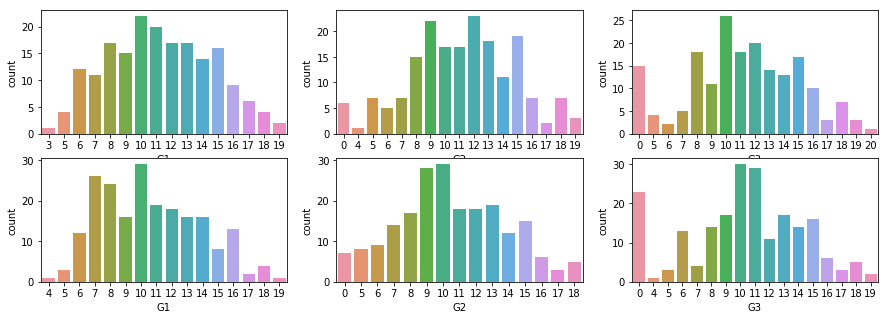

In [22]:
fig, axes = plt.subplots(2, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.countplot(x = 'G1', data = df[df['sex']=='M'],ax=axes[0,0])
sns.countplot(x = 'G2', data = df[df['sex']=='M'],ax=axes[0,1])
sns.countplot(x = 'G3', data = df[df['sex']=='M'],ax=axes[0,2])
sns.countplot(x = 'G1', data = df[df['sex']=='F'],ax=axes[1,0])
sns.countplot(x = 'G2', data = df[df['sex']=='F'],ax=axes[1,1])
sns.countplot(x = 'G3', data = df[df['sex']=='F'],ax=axes[1,2])

The patterns are almost exactly the same. Still no explanation to the G3 = 0 phenomenon.  

## Age 

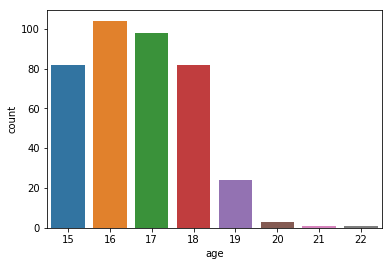

In [23]:
sns.countplot(x = 'age', data = df)

My guess is that the school is aimd for the ages: 15-18 and perhaps 19, with some people still being in school.

## Abscense 


Perhaps the large amount of people getting G3 = 0 could be attributed to a large abscense. This could be the case if you need a certain percentage of being present to get a final grade or if the student leave school early and thus get a final grade of 0. In both cases this should show up in the abscese feature

In [24]:
df[['G3','absences']].corr()

,G3,absences
G3,1.000000,0.034247
absences,0.034247,1.000000


There is some correlation, but very minimal. However, it could be the case that for a single value of G3, in this case 0, the correlation to abscence is larger. 

In [25]:
df_G3_0 = df.loc[df['G3'] == 0]

In [26]:
df_G3_0[['G3','absences']].corr()

,G3,absences
G3,NaN,NaN
absences,NaN,NaN


NaN? Did not expect that since we lack Null values. Lets use describe to see if we can figure it out. 

In [27]:
df_G3_0['absences'].describe()

count    38.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: absences, dtype: float64

There is no abscensce in for the people who get a final grade of zero. 

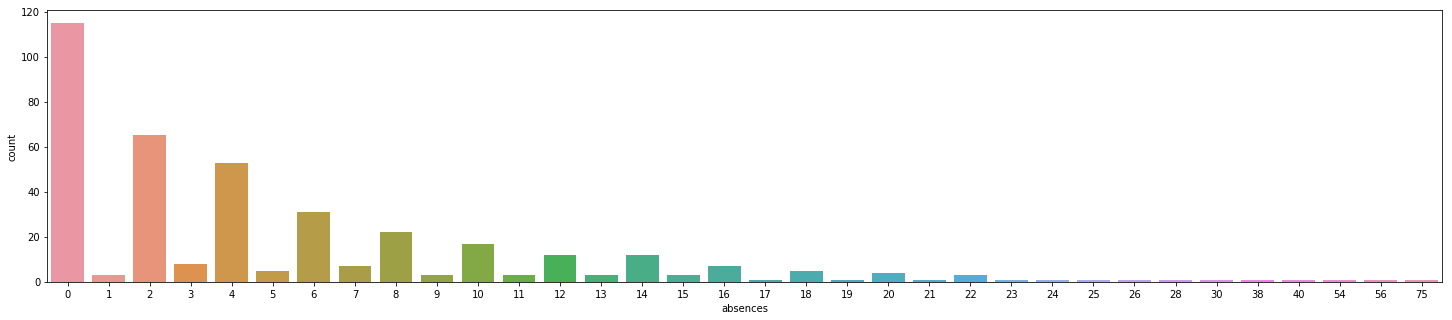

In [28]:
from matplotlib import pyplot

height = 5 
width = 25
fig, ax = pyplot.subplots(figsize=(width,height))
sns.countplot(x = 'absences', data = df)

The distribution of the abscense is weird. We would expect it to have a negative exponential distribution. But the pattern of being abscent an even amount of days is weird. 

# Pre-processing 

In [29]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


## One-hot-encoding 

In [30]:
df_ohe = pd.get_dummies(df)


## Feature Selection

In [40]:
df_ohe.loc[df_ohe['G3'] < 10, 'G3'] = 0
df_ohe.loc[df_ohe['G3'] >= 10, 'G3'] = 1


In [41]:
y = df_ohe['G3']
X = df_ohe.drop('G3', axis=1)

In [42]:
from sklearn.feature_selection import SelectKBest, chi2

k_best = SelectKBest(score_func=chi2, k=15)
k_best.fit(X, y)

df_score = pd.Series(data=k_best.scores_, index=X.columns)
df_score

age                    1.240048
Medu                   2.286991
Fedu                   2.160517
traveltime             0.261497
studytime              0.758985
failures              74.370431
famrel                 0.175027
freetime               0.040784
goout                  5.283173
Dalc                   0.694062
Walc                   0.255976
health                 0.923946
absences              37.612827
G1                   175.953380
G2                   273.800569
school_GP              0.044932
school_MS              0.340900
sex_F                  0.932542
sex_M                  1.037266
address_R              0.839169
address_U              0.240544
famsize_GT3            0.199588
famsize_LE3            0.491966
Pstatus_A              0.686909
Pstatus_T              0.079557
Mjob_at_home           0.511869
Mjob_health            2.338449
Mjob_other             1.397034
Mjob_services          1.055202
Mjob_teacher           0.000613
Fjob_at_home           0.455152
Fjob_hea

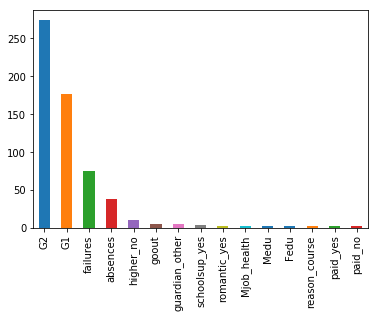

In [43]:
df_score.nlargest(15).plot(kind='bar')

In [44]:
df_ohe.corr()['G3'].nlargest(15)


G3                   1.000000
G2                   0.725407
G1                   0.664979
higher_yes           0.157708
Medu                 0.115396
Fedu                 0.108057
schoolsup_no         0.099860
romantic_no          0.097737
paid_yes             0.092665
Mjob_health          0.080484
studytime            0.074613
sex_M                0.070618
reason_reputation    0.067771
internet_yes         0.061791
Mjob_services        0.060114
Name: G3, dtype: float64

# Prediction

In [164]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix


In [94]:
classifiers = {
    'LR': LogisticRegression(),
    'RF': RandomForestClassifier(),
    'XGB': XGBClassifier(),
    'GNB': GaussianNB()
}

## Prediction without G1 and G2 

In [167]:
X_1 = X.drop(columns = ['G2','G1'])

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size = 0.25, random_state=42)
print('Number of training samples:', X_train.shape[0])
print('Number of testing samples:', X_test.shape[0])

Number of training samples: 296
Number of testing samples: 99


In [169]:
k_fold = KFold(n_splits=10, random_state=10, shuffle=True)


for key, clf in classifiers.items():
    clf.fit(X_train, y_train)
    score = cross_val_score(clf, X_train, y_train, cv=k_fold, scoring='accuracy')
    print('Acc score with CV of {0} is {1}'.format(key, score.mean()))

Acc score with CV of LR is 0.7055172413793104
Acc score with CV of RF is 0.6342528735632184
Acc score with CV of XGB is 0.6819540229885057
Acc score with CV of GNB is 0.6444827586206896


In [170]:
for key, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)

    acc = accuracy_score(y_test, y_predict)
    print(key, acc)


LR 0.7070707070707071
RF 0.6666666666666666
XGB 0.6666666666666666
GNB 0.696969696969697


In [171]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

In [172]:

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 64)                3648      
_________________________________________________________________
dense_41 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 65        
Total params: 7,873
Trainable params: 7,873
Non-trainable params: 0
_________________________________________________________________


In [173]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [174]:
X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

In [175]:
num_epoch = 3
model.fit(X_train_dl,y_train_dl,epochs = num_epoch, validation_data=(X_val_dl, y_val_dl))

Train on 222 samples, validate on 74 samples
Epoch 1/3
222/222 [==============================] - 1s 4ms/step - loss: 0.9724 - acc: 0.4685 - val_loss: 0.7003 - val_acc: 0.6892
Epoch 2/3
222/222 [==============================] - 0s 92us/step - loss: 0.7853 - acc: 0.6802 - val_loss: 0.6881 - val_acc: 0.6892
Epoch 3/3
222/222 [==============================] - 0s 91us/step - loss: 0.6642 - acc: 0.6892 - val_loss: 0.6433 - val_acc: 0.6486


In [176]:
y_pred =model.predict_classes(X_test,verbose=1)
print(accuracy_score(y_test, y_pred))


99/99 [==============================] - 0s 3ms/step
0.6363636363636364


In [177]:
confusion_matrix(y_test, y_pred)

array([[ 6, 30],
       [ 6, 57]])

## Prediction without G2

In [178]:
X_2 = X.drop(columns = ['G2'])

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size = 0.25, random_state=42)
print('Number of training samples:', X_train.shape[0])
print('Number of testing samples:', X_test.shape[0])

Number of training samples: 296
Number of testing samples: 99


In [180]:
k_fold = KFold(n_splits=10, random_state=10, shuffle=True)


for key, clf in classifiers.items():
    clf.fit(X_train, y_train)
    score = cross_val_score(clf, X_train, y_train, cv=k_fold, scoring='accuracy')
    print('Accuracy score with CV of {0} is {1}'.format(key, score.mean()))

Accuracy score with CV of LR is 0.8483908045977012
Accuracy score with CV of RF is 0.7841379310344827
Accuracy score with CV of XGB is 0.8143678160919541
Accuracy score with CV of GNB is 0.7293103448275862


In [181]:
for key, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    acc = accuracy_score(y_test, y_predict)
    print(key, acc)


LR 0.8282828282828283
RF 0.7777777777777778
XGB 0.8585858585858586
GNB 0.7474747474747475


In [182]:

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 64)                3712      
_________________________________________________________________
dense_44 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 65        
Total params: 7,937
Trainable params: 7,937
Non-trainable params: 0
_________________________________________________________________


In [183]:
X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

In [184]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epoch = 5
model.fit(X_train_dl,y_train_dl,epochs = num_epoch, validation_data=(X_val_dl, y_val_dl))

Train on 222 samples, validate on 74 samples
Epoch 1/5
222/222 [==============================] - 1s 4ms/step - loss: 0.7055 - acc: 0.6351 - val_loss: 0.5287 - val_acc: 0.7027
Epoch 2/5
222/222 [==============================] - 0s 94us/step - loss: 0.5268 - acc: 0.7207 - val_loss: 0.4157 - val_acc: 0.8514
Epoch 3/5
222/222 [==============================] - 0s 91us/step - loss: 0.4462 - acc: 0.7838 - val_loss: 0.3666 - val_acc: 0.8784
Epoch 4/5
222/222 [==============================] - 0s 93us/step - loss: 0.3980 - acc: 0.8153 - val_loss: 0.3422 - val_acc: 0.8784
Epoch 5/5
222/222 [==============================] - 0s 85us/step - loss: 0.3684 - acc: 0.8108 - val_loss: 0.3240 - val_acc: 0.8784


In [185]:
y_pred =model.predict_classes(X_test,verbose=1)
print(accuracy_score(y_test, y_pred))


99/99 [==============================] - 0s 3ms/step
0.8181818181818182


In [186]:
confusion_matrix(y_test, y_pred)

array([[24, 12],
       [ 6, 57]])

# Conclusion

Based on some preliminary models it is possible to predict if a student will fail the course without any prior exams. However, the predictive ability was increasing significantly with prior exams in the model. Imagine what could be done if data was collected over multiple years and you could follow the student through the school years. 



Note that these models only used default settings and no extensive search was done to improve the models. This work is only a proof-of-work that this kind of predictions could be done. I am without any doubt sure that the models could be improved not only be removing some features but also if data over multiple years was avalaible and used. 